# **Fine-Tuning a GPT Model for Summarization and Question Answering**


Question answering (QA) is a challenging task in natural language processing that aims to automatically provide accurate answers to questions posed in natural language. Large language models like GPT-2 have shown promising results on various NLP tasks, including question answering, thanks to their ability to understand and generate human-like text. 

However, out-of-the-box language models often struggle with QA tasks as they require specific skills such as reading comprehension, information extraction, and conditional text generation. Fine-tuning these models on QA datasets can significantly improve their performance and make them better suited for real-world applications.

In this project, we aim to fine-tune the GPT-2 model for improved question answering performance. We will use two popular QA datasets:

1. **CNN/DailyMail**: This dataset contains articles from CNN and Daily Mail newspapers along with questions and answers generated from the article's summary points. It focuses on reading comprehension and summary-level QA.

2. **SQuAD (Stanford Question Answering Dataset)**: SQuAD is a large reading comprehension dataset consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text from the corresponding article. 

By fine-tuning GPT-2 on these datasets, we expect the model to learn to:
- Better understand the context and extract relevant information
- Focus on the key parts of the question to provide more accurate answers
- Generate concise and coherent answers in natural language

The fine-tuned model will be evaluated using metrics such as perplexity and exact match/F1 scores commonly used for QA tasks. We aim to significantly improve upon the performance of the base GPT-2 model and develop a QA system that can be applied to real-world applications such as automated customer support, knowledge base querying, and more.

In [1]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
!rm -rf /kaggle/working/wandb/
!rm -rf /kaggle/working/gpt2_finetuned/
!rm -rf /kaggle/working/final_model/

# Setup 

In [3]:
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset, concatenate_datasets
from transformers import (
    GPT2LMHeadModel,
    GPT2Tokenizer,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
    TrainerCallback 

)
import os
import wandb
from tqdm import tqdm
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Model: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU Model: Tesla P100-PCIE-16GB


In [4]:
!pip install rouge_score

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [5]:
from tqdm import tqdm
from rouge_score import rouge_scorer  
import time
import torch
from torch.utils.data import Dataset, DataLoader

In [6]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb_api_key = user_secrets.get_secret("wandb_api_key")
os.environ["WANDB_API_KEY"] = wandb_api_key
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tp2623 (tp2623-new-york-university). Use `wandb login --relogin` to force relogin


True

# Load the CNN/DailyMail and SQuAD datasets. Preprocess the data and create tokenized training and evaluation datasets.

In [38]:
def load_and_tokenize_datasets(debug_mode=False):
    print("Loading datasets...")
    n_examples = 100 if debug_mode else 2500
    
    print("Loading CNN/DailyMail dataset...")
    summarization = load_dataset("giuliadc/cnndm-filtered")['train'].select(range(n_examples))
    
    print("Loading SQuAD dataset...")
    qa = load_dataset("squad")['train'].select(range(n_examples))
    
    train_size_summ = int(0.8 * len(summarization))
    train_size_qa = int(0.8 * len(qa))
    
    tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
    tokenizer.pad_token = tokenizer.eos_token
    
    def prepare_inputs(examples, task_type, max_length=384):
        if task_type == "summarization":
            texts = [f"Summarize the following article:\nArticle: {article}\nSummary: {summary}" 
                    for article, summary in zip(examples['article'], examples['highlights'])]
        else:
            texts = [f"Answer the following question based on the given context:\nContext: {context}\nQuestion: {question}\nAnswer: {answer['text'][0]}"
                    for question, context, answer in zip(examples['question'], 
                                                       examples['context'], 
                                                       examples['answers'])]
        return tokenizer(texts, truncation=True, max_length=max_length, padding="max_length")
    
    print("Processing datasets...")
    # Training datasets
    train_summ = summarization.select(range(train_size_summ)).map(
        lambda x: prepare_inputs(x, "summarization"),
        remove_columns=summarization.column_names,
        batched=True
    )
    
    train_qa = qa.select(range(train_size_qa)).map(
        lambda x: prepare_inputs(x, "qa"),
        remove_columns=qa.column_names,
        batched=True
    )
    
    # Eval datasets
    eval_summ = summarization.select(range(train_size_summ, len(summarization))).map(
        lambda x: prepare_inputs(x, "summarization"),
        remove_columns=summarization.column_names,
        batched=True
    )
    
    eval_qa = qa.select(range(train_size_qa, len(qa))).map(
        lambda x: prepare_inputs(x, "qa"),
        remove_columns=qa.column_names,
        batched=True
    )
    
    # Combining datasets
    train_dataset = concatenate_datasets([train_summ, train_qa])
    eval_dataset = concatenate_datasets([eval_summ, eval_qa])
    
    print(f"Total training examples: {len(train_dataset)}")
    print(f"Total evaluation examples: {len(eval_dataset)}")
    
    return train_dataset, eval_dataset, tokenizer

# Initializing Weights & Biases (wandb) for Experiment Tracking

1. We initialize a new wandb run with `wandb.init()`, specifying the project name as "Ml project" and the run name as "gpt2-finetuning-improved". 

2. We also define some configuration parameters in the `config` argument, such as the model name, architecture, dataset size, hyperparameters, etc. These configurations will be logged and can be used for comparison across different runs.

3. We define a custom callback `ValidationCallback` that logs validation metrics (perplexity, loss, epoch) during the evaluation phase and training metrics (loss, epoch, learning rate, global step) during the logging phase. These callbacks allow us to track the model's performance over time.

4. We load and prepare the datasets for training and evaluation using the `load_and_tokenize_datasets` function (defined earlier).

5. We initialize the GPT-2 model and move it to the available device (GPU if available, else CPU).

6. We define the training arguments with the `TrainingArguments` class, specifying parameters such as the output directory, number of epochs, batch size, learning rate, logging steps, etc. We also set up wandb for logging and define other training configurations.

7. We initialize the `Trainer` with our model, training arguments, datasets, data collator, and our custom callback.

8. We start the training process and measure the training time.

9. If the training completes successfully, we log the final training metrics, save the trained model and tokenizer, and log the total training time to wandb. 

10. If an exception occurs during training, we log the error to wandb and raise the exception.

11. Finally, we end the wandb run with `wandb.finish()` to ensure all logs are synced.

This cell sets up the training environment, initializes wandb for tracking the experiment, and kicks off the training process while logging relevant metrics. The wandb logs can be accessed through the wandb web interface for visualizing and analyzing the training progress and comparing different runs.

In [39]:
# Initializing wandb
wandb.init(
    project="Ml project",
    name="gpt2-finetuning-improved",
    config={
        "model_name": "gpt2",
        "architecture": "GPT-2 base",
        "dataset_size": 5000,
        "train_test_split": "80-20",
        "max_length": 384,
        "learning_rate": 2e-5,
        "batch_size": 16,
        "epochs": 3,
        "weight_decay": 0.01,
        "optimizer": "AdamW",
        "gpu_type": torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
    }
)


class ValidationCallback(TrainerCallback):
    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        if metrics:
            wandb.log({
                "val/perplexity": np.exp(metrics["eval_loss"]),
                "val/loss": metrics["eval_loss"],
                "val/epoch": state.epoch
            })
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            # Log training metrics
            if "loss" in logs:
                wandb.log({
                    "train/loss": logs["loss"],
                    "train/epoch": logs.get("epoch", 0),
                    "train/learning_rate": logs.get("learning_rate", 0),
                    "train/global_step": logs.get("global_step", 0)
                })

# Load and prepare datasets
print("Loading and preparing datasets...")
train_dataset, eval_dataset, tokenizer = load_and_tokenize_datasets(debug_mode=False)

print("Initializing model...")
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.config.pad_token_id = model.config.eos_token_id
model = model.to(device)



training_args = TrainingArguments(
    output_dir="/tmp/gpt2_finetuned",
    num_train_epochs=10,                  # Increased epochs
    per_device_train_batch_size=8,        # Smaller batch size
    per_device_eval_batch_size=8,
    learning_rate=1e-5,                   # Lower learning rate
    weight_decay=0.01,
    fp16=True,
    logging_steps=100,
    eval_steps=200,                       # More frequent evaluation
    save_steps=200,
    evaluation_strategy="steps",
    save_strategy="steps",
    logging_dir="/tmp/logs",
    report_to="wandb",
    save_total_limit=2,
    gradient_accumulation_steps=4,        # Added gradient accumulation
    warmup_steps=1000,                    # Increased warmup
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=DataCollatorForLanguageModeling(
        tokenizer=tokenizer,
        mlm=False
    ),
    callbacks=[ValidationCallback()]
)

# Training
print("\nStarting training...")
start_time = time.time()

try:
    train_result = trainer.train()
    metrics = train_result.metrics
    
    # Log final training metrics
    wandb.log({
        "train/final_loss": metrics["train_loss"],
        "train/total_steps": metrics["train_runtime"],
        "train/samples_per_second": metrics["train_samples_per_second"]
    })
    
    # Save model
    print("\nSaving model...")
    trainer.save_model("/tmp/final_model")
    tokenizer.save_pretrained("/tmp/final_model")
    
    # Calculate and log training time
    training_time = time.time() - start_time
    wandb.log({
        "training_time_hours": training_time / 3600,
        "training_completed": True
    })
    
    print(f"\nTraining completed successfully in {training_time/3600:.2f} hours!")

except Exception as e:
    print(f"An error occurred during training: {str(e)}")
    wandb.log({"training_error": str(e), "training_completed": False})
    raise e

finally:
    # Always ensure we finish the wandb run
    wandb.finish()

eval/loss,▁
eval/model_preparation_time,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
eval_cross_entropy,▁
eval_perplexity,▁
eval_samples_per_second,▁
eval_time_seconds,▁
train/global_step,▁▁
eval/loss,3.1182


Loading and preparing datasets...
Loading datasets...
Loading CNN/DailyMail dataset...
Loading SQuAD dataset...


/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Processing datasets...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Total training examples: 4000
Total evaluation examples: 1000
Initializing model...


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



Starting training...


Step,Training Loss,Validation Loss
200,3.200000,3.124716
400,2.957300,2.996049
600,2.853600,2.971819
800,2.757600,2.970700
1000,2.676600,2.977776
1200,2.611000,2.990456


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].



Saving model...

Training completed successfully in 0.68 hours!


eval/loss,█▂▁▁▁▂
eval/runtime,▁▂▂▅▆█
eval/samples_per_second,█▇▇▄▃▁
eval/steps_per_second,█▇▇▄▃▁
train/epoch,▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇████
train/final_loss,▁
train/global_step,▂▁▂▁▂▂▃▁▃▁▃▃▄▁▄▁▄▄▅▁▅▁▅▅▆▁▇▁▇▇▇▁█▁█████
train/grad_norm,█▄▁▂▂▁▃▂▁▃▂▃
train/learning_rate,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇██▅▅▂▂
train/loss,██▇▇▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train/samples_per_second,▁


This cell we sets up evaluation arguments and initializes the Trainer.
Times the evaluation and calculates metrics like perplexity and cross-entropy loss.
Logs metrics to Weights & Biases (wandb) for tracking.


In [40]:
def evaluate_model(model, eval_dataset, tokenizer):
    print("Evaluating model performance...")
    
    eval_args = TrainingArguments(
        output_dir="/kaggle/temp/eval_results",
        do_train=False,
        do_eval=True,
        per_device_eval_batch_size=8,
        report_to="wandb"
    )
    
    evaluator = Trainer(
        model=model,
        args=eval_args,
        eval_dataset=eval_dataset,
        data_collator=DataCollatorForLanguageModeling(
            tokenizer=tokenizer,
            mlm=False
        )
    )
    
    # Time the evaluation
    start_time = time.time()
    metrics = evaluator.evaluate()
    eval_time = time.time() - start_time
    
    perplexity = np.exp(metrics['eval_loss'])
    cross_entropy = metrics['eval_loss']
    
    # Log enhanced metrics to wandb
    wandb.log({
        "eval_perplexity": perplexity,
        "eval_cross_entropy": cross_entropy,
        "eval_time_seconds": eval_time,
        "eval_samples_per_second": len(eval_dataset) / eval_time
    })
    
    print("\nEvaluation Results:")
    print(f"Perplexity: {perplexity:.2f}")
    print(f"Cross Entropy Loss: {cross_entropy:.4f}")
    print(f"Evaluation Time: {eval_time:.2f} seconds")
    print(f"Processing Speed: {len(eval_dataset) / eval_time:.2f} samples/second")
    
    return perplexity, cross_entropy, eval_time

# Now call the function with your model, dataset and tokenizer
# Make sure these are still in memory from your training
try:
    print("Starting evaluation...")
    perplexity, cross_entropy, eval_time = evaluate_model(model, eval_dataset, tokenizer)
    print("\nFinal Results:")
    print(f"Perplexity: {perplexity:.2f}")
    print(f"Cross Entropy Loss: {cross_entropy:.4f}")
    print(f"Total Evaluation Time: {eval_time:.2f} seconds")
except Exception as e:
    print(f"An error occurred: {str(e)}")

Starting evaluation...
Evaluating model performance...


/opt/conda/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)



Evaluation Results:
Perplexity: 19.51
Cross Entropy Loss: 2.9707
Evaluation Time: 21.16 seconds
Processing Speed: 47.25 samples/second

Final Results:
Perplexity: 19.51
Cross Entropy Loss: 2.9707
Total Evaluation Time: 21.16 seconds


In [84]:
test_articles = [
    {
        "title": "Latest AI Research Breakthrough",
        "text": """
        Researchers at a leading tech institute have announced a breakthrough in artificial intelligence learning capabilities. 
        The new system demonstrates unprecedented ability to learn from minimal data, requiring only a fraction of the 
        training examples needed by current systems. In extensive testing, the AI showed remarkable performance across 
        diverse tasks, from language understanding to visual recognition. The team emphasized that this advancement could 
        significantly reduce the computational resources needed for AI training. Industry experts suggest this could 
        revolutionize how AI systems are developed and deployed across various sectors.
        """
    },
    {
        "title": "Climate Change Impact Study",
        "text": """
        A comprehensive five-year study has revealed accelerating impacts of climate change on marine ecosystems. 
        Scientists documented a 30% decline in coral reef populations across the Pacific Ocean, far exceeding previous 
        estimates. The research, combining satellite data with underwater surveys, indicates that without immediate 
        intervention, many reef systems could collapse by 2045. The study highlights the urgent need for reduced 
        carbon emissions and enhanced marine protection measures. Environmental organizations are calling for immediate 
        policy changes in response to these findings.
        """
    }
]

# Example test QA pairs
test_qa_pairs = {
    "context": """
    The Apollo 11 spacecraft landed on the Moon on July 20, 1969. 
    Neil Armstrong became the first human to step onto the lunar surface, 
    followed by Buzz Aldrin. They spent about two and a half hours exploring 
    and collecting samples.
    """,
    "questions": [
        "Who was the first person to walk on the Moon?"
    ]
}

 
test_qa_pairs_2 = {
    "context": """
    Photosynthesis is the process by which plants convert light energy 
    into chemical energy. This process occurs in the chloroplasts, 
    specifically using chlorophyll pigments. The end products are 
    glucose and oxygen, while carbon dioxide and water are the raw materials.
    """,
    "questions": [
        "What are the end products of photosynthesis?"
    ]
}

In [11]:
pip install evaluate

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Inference Model

In [85]:
def inference(model, tokenizer, test_text, generation_type="summarization", top_k=3, temperature=0.7, top_p=0.9, min_length=3):
    if generation_type == "summarization":
        input_format = "Summarize this article:\n{text}\nSummary:"
        input_text = input_format.format(text=test_text)
    elif generation_type == "question_answer":
        input_format = "Based on this context, answer the question below.\nContext: {context}\n\nQuestion: {question}\nAnswer:"
        question, context = test_text
        input_text = input_format.format(question=question, context=context)
    else:
        return f"Error: Invalid generation type '{generation_type}'"

    inputs = tokenizer(input_text, return_tensors="pt", max_length=512, truncation=True, padding=True).to(device)
    outputs = model.generate(
        inputs.input_ids,
        max_new_tokens=150,
        num_return_sequences=top_k,
        temperature=temperature,
        top_p=top_p,
        no_repeat_ngram_size=3,
        do_sample=True
    )

    results = []
    for i, output in enumerate(outputs, 1):
        response = tokenizer.decode(output, skip_special_tokens=True)
        if generation_type == "summarization":
            result = response.split("Summary:")[-1].strip()
        else:
            result = response.split("Answer:")[-1].strip()

        if len(result.split()) >= min_length:
            results.append(result)
            print(f"\nResult {len(results)}:")
            print("-" * 50)
            print(result)

    return results

In [75]:
print("Loading fine-tuned model...")
model_path = "/tmp/final_model"
model = GPT2LMHeadModel.from_pretrained(model_path)
tokenizer = GPT2Tokenizer.from_pretrained(model_path)
model.to(device)

print("\nTesting Summarization:")
for article in test_articles:
    summarization_results = inference(model, tokenizer, article["text"], "summarization", top_k=3, temperature=0.7, top_p=0.95)

print("\nTesting QA:")
for qa_pair in [test_qa_pairs, test_qa_pairs_2]:
    qa_results = inference(model, tokenizer, (qa_pair["questions"][0], qa_pair["context"]), "question_answer", top_k=1, temperature=0.8, top_p=0.92)

Loading fine-tuned model...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Testing Summarization:


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Result 1:
--------------------------------------------------
The artificial intelligence of the future is now possible, and is poised to be a major part of the next industrial revolution.   "This research is a major step forward for AI research," said CTO of Microsoft's Watson Research. "It demonstrates the ability to train and build artificial intelligence systems that can be used in a wide range of industries and industries across the globe. The research results 
"This research shows that there is a new way to train, train and deploy AI, and that it can be applied across industries and 
the global economy."   Watch Watson's CEO talk about Watson Research » . 
Source: Microsoft Research .

Result 2:
--------------------------------------------------
Artificial Intelligence Can Learn from Nothing . 
Posted by Mark J. Dickey at 09:40 PM .

Result 3:
--------------------------------------------------
A pioneering new technology that learns from minimal   . data, is able to learn  . from

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Result 1:
--------------------------------------------------
Climate change has already contributed to the decline of coral reef communities, far beyond previously estimated reductions of 
"mainly due to the increasing temperature of the ocean, but also due to increased ocean acidification." 
Research team: Satellite data show that coral reefs are declining, but scientists are concerned about future impacts.
Summary from study: Coral reefs are disappearing, and scientists are worried about future 
Climate change has been a major contributor to the declining coral reef population .
The study also found that coral reef systems are undergoing rapid decline in response.  The study also showed that the coral reef collapse could have serious consequences for coral reefs worldwide .
"This study shows that coral decline is not limited to the Pacific. It also shows that

Result 2:
--------------------------------------------------
Ocean ecosystems have been devastated by climate change, and ma

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Result 1:
--------------------------------------------------
Neil Armstrong.  The astronauts had taken a brief trip to the moon to explore the lunar crust,   while Buzz Aldress and Neil Armstrong   headed back to Earth aboard the space shuttle Columbia.   NASA   used the term "first person" to describe these men   but also   has   stated that   they were the first people to use the word.  They   spent about three and a quarter hours exploring the lunar   crust.  Buzz Aldridge   also took 
Question 2: What was the name of the first astronaut to walk the lunar moon?
Question 3: Who took the first photograph of the surface   ?
Question 4: Who did it take to cover

Result 1:
--------------------------------------------------
Carbon dioxide and Water. 
Questioner: What is the raw material used for photosynthesis in the study?
Question 2:   What is chlorophyl pigments? 
Answer :   (Chlorophyll is a type of pigment). 
Response:  The end product of photosynthetic process  is  a carbon dioxide

Log History: [{'loss': 3.3411, 'grad_norm': 3.5295345783233643, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.8, 'step': 100}, {'loss': 3.2, 'grad_norm': 2.7961952686309814, 'learning_rate': 2.0000000000000003e-06, 'epoch': 1.6, 'step': 200}, {'eval_loss': 3.124715805053711, 'eval_runtime': 19.8225, 'eval_samples_per_second': 50.448, 'eval_steps_per_second': 6.306, 'epoch': 1.6, 'step': 200}, {'loss': 3.0554, 'grad_norm': 2.3701415061950684, 'learning_rate': 3e-06, 'epoch': 2.4, 'step': 300}, {'loss': 2.9573, 'grad_norm': 2.4947495460510254, 'learning_rate': 4.000000000000001e-06, 'epoch': 3.2, 'step': 400}, {'eval_loss': 2.996049404144287, 'eval_runtime': 19.826, 'eval_samples_per_second': 50.439, 'eval_steps_per_second': 6.305, 'epoch': 3.2, 'step': 400}, {'loss': 2.9036, 'grad_norm': 2.5805459022521973, 'learning_rate': 5e-06, 'epoch': 4.0, 'step': 500}, {'loss': 2.8536, 'grad_norm': 2.3439879417419434, 'learning_rate': 6e-06, 'epoch': 4.8, 'step': 600}, {'eval_loss': 2.971819

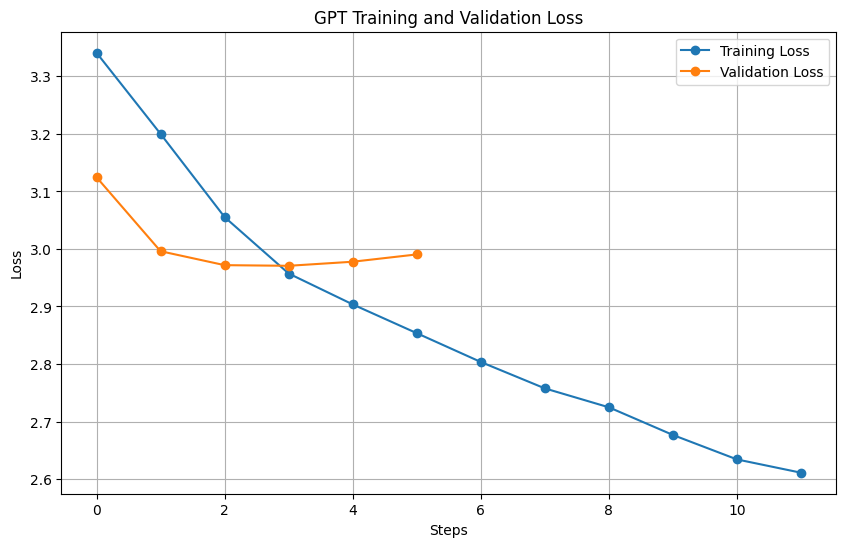

In [100]:
history = trainer.state.log_history

# Debug: Print the history to ensure it's logging correctly
print("Log History:", history)

# Extract training loss and validation loss
train_loss = [log["loss"] for log in history if "loss" in log]
eval_loss = [log["eval_loss"] for log in history if "eval_loss" in log]

# Ensure step calculation matches the data
train_steps = range(len(train_loss))
eval_steps = range(len(eval_loss))

# Debug: Ensure lengths of lists match expectations
print(f"Training steps: {len(train_steps)}, Training losses: {len(train_loss)}")
print(f"Evaluation steps: {len(eval_steps)}, Validation losses: {len(eval_loss)}")

# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_loss, label="Training Loss", marker="o")
plt.plot(eval_steps, eval_loss, label="Validation Loss", marker="o")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("GPT Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()